### 1.KNN无线定位方法

##### 1.1读取下载的数据集作为指纹
数据集下载地址：<a>https://archive.ics.uci.edu/ml/datasets/ujiindoorloc  
其中有520个WAP即参考点，100表示在此处接收不到对应AP的信号  
经度:从 -7695.9387549299299000 到 -7299.786516730871000 的负实数值  
纬度:从 4864745.7450159714 到 4865017.3646842018 的正实数值。

<a>https://earthscience.stackexchange.com/questions/19317/how-to-interpret-these-kind-of-coordinates  
这里我查找了一下资料，发现数据集的经纬度使用的是 EPSG:3857 WGS 84 / Pseudo-Mercator 坐标（伪墨卡托坐标） 谷歌 高德 腾讯 百度等地图等都使用该坐标系  
单位为米

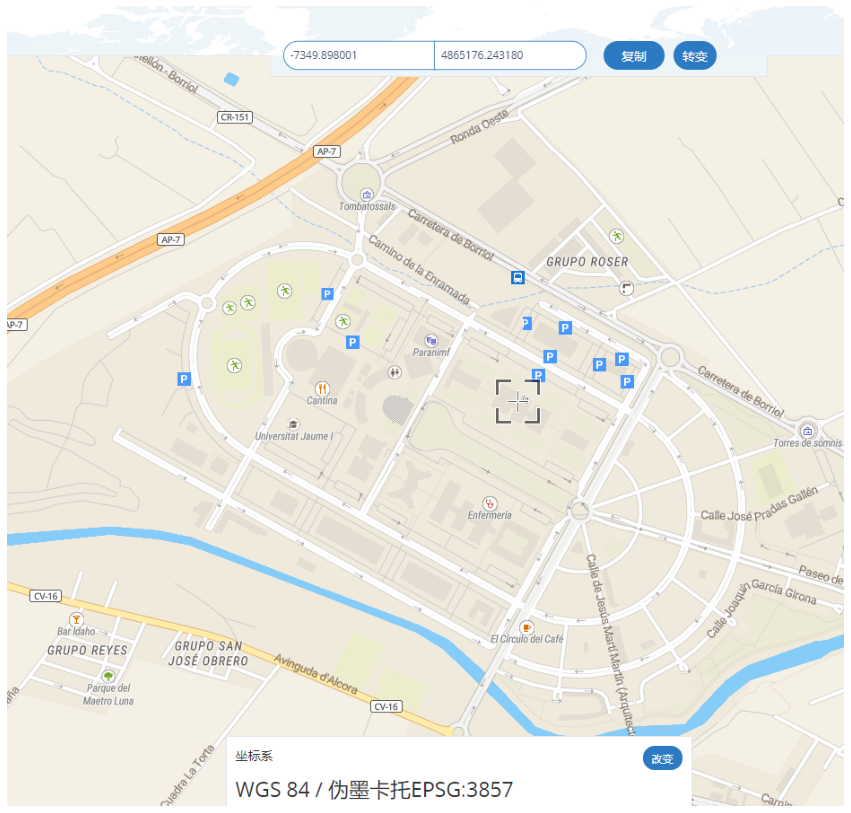

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img = Image.open('10.png')
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(img)

In [17]:
import pandas as pd

# 准备指纹
df=pd.read_csv("floor0.csv")
finger_ori=df.iloc[:,:-9]
location_ori=df.iloc[:,-9:-7]

In [18]:
location_ori

,LONGITUDE,LATITUDE
0,-7632.143600,4864982.217
1,-7474.553800,4864866.856
2,-7469.871500,4864864.365
3,-7466.445299,4864859.364
4,-7454.239100,4864829.266
...,...,...
4364,-7311.829500,4864805.727
4365,-7318.694800,4864795.302
4366,-7314.611700,4864800.712
4367,-7320.078900,4864794.328


In [19]:
# 为了节省时间，读取前100个验证集，假设是在线阶段的数据
df_val=pd.read_csv("val.csv")
finger_val=df_val.iloc[:100,:-9]
location_val=df_val.iloc[:100,-9:-7]

In [20]:
import numpy as np

# 将df转为np方便处理
finger_ori=np.array(finger_ori)
location_ori=np.array(location_ori)

finger_val=np.array(finger_val)
location_val=np.array(location_val)

In [21]:
class knn_location:
    def __init__(self,finger_ori,location_ori,finger_val,location_val):
        self.finger_ori=finger_ori
        self.location_ori=location_ori
        self.finger_val=finger_val
        self.location_val=location_val

    def compute(self):
        d_all=[]
        d_min=9999
        min_i=-1
        min_j=-1
        # 0-100
        for j in range(0,len(finger_val)):
            # 0-4368
            for i in range(0,len(self.finger_ori)):
                # (np.sum((np.array([5,4])-np.array([1,1]))**2))**0.5 计算欧氏距离
                d=(np.sum((finger_val[j]-finger_ori[i])**2))**0.5
                d_all.append(d)
                if d<d_min:
                    d_min=d
                    min_i=i
                    min_j=j
        return d_all,d_min

In [22]:
knn=knn_location(finger_ori,location_ori,finger_val,location_val)
d_all,d_min=knn.compute()

In [24]:
# 把所有的欧式距离转换为np数组
d_all=np.array(d_all)
# 重组为（100，4369）每一行表示一个待测点与指纹集的所有距离
d_all=d_all.reshape(-1,len(finger_ori))

In [25]:
d_all.shape

(100, 4369)

In [26]:
def bubble(d_all,label,k): 
#  冒泡法 
  length = len(d_all) 
  for i in range(k): 
    for j in range(i+1,length): 
      if d_all[i] > d_all[j]: 
        d_all[j],d_all[i] = d_all[i],d_all[j]
        label[j],label[i]= label[i],label[j]
  return d_all[0:k],label[0:k]

In [27]:
k=10
d_sort_all=[]
label_sort_all=[]

for val in range(0,len(finger_val)):
    label=np.array(range(0,len(finger_ori)))
    d_sort,label_sort=bubble(d_all[val],label,k)
    d_sort_all.append(d_sort)
    label_sort_all.append(label_sort)

In [28]:
pre=[]
for d in range(0,len(d_sort_all)):
    k_location=location_ori[label_sort_all[d]]
    pre.append(np.sum(k_location.T,axis=1)/k)

In [29]:
pre=np.array(pre)
# 计算平均定位误差
errors=np.sum((np.sum((pre-location_val)**2,axis=1))**0.5)/len(finger_val)
errors

21.680143157847603